In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('./Binance_BTCUSDT_1h.csv', date_parser = True)
df = df.reindex(-np.sort(-np.arange(len(df))))
df.tail()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
4,1.638990e+12,2021/12/8 20:00,BTC/USDT,50423.20,50896.08,50318.55,50689.01,1294.19176,65497668.23,38573.0
3,1.639000e+12,2021/12/8 21:00,BTC/USDT,50689.01,50827.39,50474.37,50589.94,871.90891,44169699.23,31746.0
2,1.639000e+12,2021/12/8 22:00,BTC/USDT,50589.93,50822.17,50079.78,50224.42,1079.50101,54531929.92,40691.0
1,1.639000e+12,2021/12/8 23:00,BTC/USDT,50224.42,50575.81,50165.31,50471.19,971.89830,48998640.80,33395.0
0,1.639010e+12,2021/12/9 00:00,BTC/USDT,50471.19,50797.76,50435.58,50713.84,348.62747,17655072.46,11293.0


In [3]:
#擷取⽇期及收盤價
df2 = df.loc[:, ('date','close', 'open','high','low','Volume BTC')] ; del df ; gc.collect()
#切出⽇期時間欄位，符號統⼀
df2['NewDate'] = df2.loc[:, 'date'].str.slice(start = 0, stop = 10).str.replace('-', '/').str.replace('/0', '/').str.rsplit(pat=' ', n=1).apply(lambda x : x[0])
#判斷⽇期欄位格式
df2['AMPM'] = df2.loc[:, 'date'].str.contains(pat = 'AM|PM')
#依⽇期欄位格式切分兩分DF，有AMPM的在df3，正常格式的在df4
df3 = df2[df2['AMPM'] == 1]
df4 = df2[df2['AMPM'] == 0]
del df2 ; gc.collect()


23

In [4]:
#切出⽇期欄位中的⼩時
df3['Hour'] = df3.loc[:, 'date'].str.slice(start = 10, stop = 13).str.replace(':', '').apply(lambda x : pd.to_numeric(x))
df3['AMPM'] = df3.loc[:, 'date'].str.slice(start = 14, stop = 16).apply(lambda x: 12 if (x == 'PM') else 0)
df3['24Hr'] = (df3['Hour'] + df3['AMPM'])
#轉換為24⼩時制
df3['24Hr'] = df3['24Hr'].apply(lambda x: (x == 24 and 12) or (x == 12 and '00') or x)
df3['24Hr'] = df3['24Hr'].apply(lambda x: '0'+str(x) if len(str(x)) == 1 else str(x))

#轉為時間格式
df3['NewDateTime'] = (df3['NewDate'] + ' ' +df3['24Hr'])
df3['NewDateTime'] = df3['NewDateTime'].apply(lambda x: pd.to_datetime(x, format = "%Y/%m/%d %H"))
#移除重複
df3 = df3[['close', 'open','high','low','Volume BTC', 'NewDateTime','NewDate']].drop_duplicates()
df3.head()

,close,open,high,low,Volume BTC,NewDateTime,NewDate
40423,4308.83,16199.91,16199.91,4261.32,44.5100,2017-08-17 04:00:00,2017/8/17
40422,4315.32,4308.83,4328.69,4291.37,23.2300,2017-08-17 05:00:00,2017/8/17
40421,4324.35,4315.32,4345.45,4309.37,7.2300,2017-08-17 06:00:00,2017/8/17
40420,4349.99,4324.35,4349.99,4287.41,4.4400,2017-08-17 07:00:00,2017/8/17
40419,4360.69,4349.99,4377.85,4333.32,0.9499,2017-08-17 08:00:00,2017/8/17


In [5]:
#轉為時間格式並移除重複
df4['NewDateTime'] = df4['date'].apply(lambda x: pd.to_datetime(x, format = "%Y/%m/%d %H:%M"))
df4 = df4[['close', 'open','high','low','Volume BTC', 'NewDateTime','NewDate']].drop_duplicates()
df4.head()

,close,open,high,low,Volume BTC,NewDateTime,NewDate
14487,11801.17,11783.31,11820.61,11731.71,2194.598589,2020-08-01 23:00:00,2020/8/1
14485,11782.63,11801.17,11857.00,11740.00,2872.638184,2020-08-02 00:00:00,2020/8/2
14483,11942.55,11782.63,11942.55,11772.13,3707.136801,2020-08-02 01:00:00,2020/8/2
14481,11928.58,11942.54,11965.01,11892.88,3785.415559,2020-08-02 02:00:00,2020/8/2
14479,12000.00,11928.40,12000.00,11870.00,3746.422743,2020-08-02 03:00:00,2020/8/2


In [6]:
#合併df3、df4，並移除重複
df5 = pd.concat([df3, df4]) ; df6 = df5.drop_duplicates()
#確認刪除多少資料
print(len(df5), len(df6))
del (df3, df4, df5)
gc.collect()


40424 40424


0

In [7]:
#投報率
df6['returns']=df6['close']/df6['close'].shift(1)
df6['log_returns']=np.log(df6['returns'])
df6 = df6[df6['returns'].notna()]
# df6.dropna()
df6.head()

,close,open,high,low,Volume BTC,NewDateTime,NewDate,returns,log_returns
40422,4315.32,4308.83,4328.69,4291.37,23.2300,2017-08-17 05:00:00,2017/8/17,1.001506,0.001505
40421,4324.35,4315.32,4345.45,4309.37,7.2300,2017-08-17 06:00:00,2017/8/17,1.002093,0.002090
40420,4349.99,4324.35,4349.99,4287.41,4.4400,2017-08-17 07:00:00,2017/8/17,1.005929,0.005912
40419,4360.69,4349.99,4377.85,4333.32,0.9499,2017-08-17 08:00:00,2017/8/17,1.002460,0.002457
40418,4444.00,4360.69,4445.78,4360.00,10.7600,2017-08-17 09:00:00,2017/8/17,1.019105,0.018925


In [8]:
#依照年份及週次分組
df6['Year'] = df6.loc[:, 'NewDateTime'].dt.year
df6['Week'] = df6.loc[:, 'NewDateTime'].dt.isocalendar().week
test = np.array(df6.groupby(['Year', 'Week']), dtype = object).T
#排除⻑度不為168的array
Array = np.empty([1, 168])
for i in range(0, len(np.array(test[1]))):
    if len(np.array(test[1][i]['close'])) == 168 :
        Array = np.append(Array, np.array(test[1][i]['close']).reshape(1, -1), axis = 0)

In [9]:
df6.head()

,close,open,high,low,Volume BTC,NewDateTime,NewDate,returns,log_returns,Year,Week
40422,4315.32,4308.83,4328.69,4291.37,23.2300,2017-08-17 05:00:00,2017/8/17,1.001506,0.001505,2017,33
40421,4324.35,4315.32,4345.45,4309.37,7.2300,2017-08-17 06:00:00,2017/8/17,1.002093,0.002090,2017,33
40420,4349.99,4324.35,4349.99,4287.41,4.4400,2017-08-17 07:00:00,2017/8/17,1.005929,0.005912,2017,33
40419,4360.69,4349.99,4377.85,4333.32,0.9499,2017-08-17 08:00:00,2017/8/17,1.002460,0.002457,2017,33
40418,4444.00,4360.69,4445.78,4360.00,10.7600,2017-08-17 09:00:00,2017/8/17,1.019105,0.018925,2017,33


In [10]:
# 加入SOPR
df_SOPR = pd.read_csv('./sopr-btc-24h.csv', date_parser = True)
df_SOPR = df_SOPR.reindex(-np.sort(-np.arange(len(df_SOPR))))
df_SOPR.tail()
df_SOPR2 = df_SOPR.loc[:, ('t','v')] ; del df_SOPR ; gc.collect()
#切出⽇期時間欄位，符號統⼀
df_SOPR2['NewDate'] = df_SOPR2.loc[:, 't'].str.slice(start = 0, stop = 10).str.replace('-', '/').str.replace('/0', '/').str.rsplit(pat=' ', n=1).apply(lambda x : x[0])
df_SOPR2 = df_SOPR2[['v','NewDate']].drop_duplicates()
result = pd.merge(df6,df_SOPR2, on='NewDate')
result.head()

,close,open,high,low,Volume BTC,NewDateTime,NewDate,returns,log_returns,Year,Week,v
0,7177.02,7195.23,7196.25,7175.46,480.93,2020-01-01 00:00:00,2020/1/1,0.997469,-0.002534,2020,1,0.997801
1,7216.27,7177.02,7230.00,7175.71,836.51,2020-01-01 01:00:00,2020/1/1,1.005469,0.005454,2020,1,0.997801
2,7242.85,7216.27,7244.87,7211.41,626.60,2020-01-01 02:00:00,2020/1/1,1.003683,0.003677,2020,1,0.997801
3,7225.01,7242.85,7245.00,7220.00,748.76,2020-01-01 03:00:00,2020/1/1,0.997537,-0.002466,2020,1,0.997801
4,7217.27,7225.01,7230.00,7215.03,442.09,2020-01-01 04:00:00,2020/1/1,0.998929,-0.001072,2020,1,0.997801


In [11]:
data_training = result[result['NewDateTime']>= '2020-01-01'].copy()
data_training = data_training[data_training['NewDateTime']< '2021-10-08'].copy()
data_training

,close,open,high,low,Volume BTC,NewDateTime,NewDate,returns,log_returns,Year,Week,v
0,7177.02,7195.23,7196.25,7175.46,480.93000,2020-01-01 00:00:00,2020/1/1,0.997469,-0.002534,2020,1,0.997801
1,7216.27,7177.02,7230.00,7175.71,836.51000,2020-01-01 01:00:00,2020/1/1,1.005469,0.005454,2020,1,0.997801
2,7242.85,7216.27,7244.87,7211.41,626.60000,2020-01-01 02:00:00,2020/1/1,1.003683,0.003677,2020,1,0.997801
3,7225.01,7242.85,7245.00,7220.00,748.76000,2020-01-01 03:00:00,2020/1/1,0.997537,-0.002466,2020,1,0.997801
4,7217.27,7225.01,7230.00,7215.03,442.09000,2020-01-01 04:00:00,2020/1/1,0.998929,-0.001072,2020,1,0.997801
...,...,...,...,...,...,...,...,...,...,...,...,...
18130,53962.76,53895.90,54161.82,53802.18,1244.49099,2021-10-07 19:00:00,2021/10/7,1.001241,0.001240,2021,40,1.007150
18131,54167.17,53962.75,54324.87,53890.00,1066.88373,2021-10-07 20:00:00,2021/10/7,1.003788,0.003781,2021,40,1.007150
18132,54275.62,54167.18,54500.00,54036.00,1346.45466,2021-10-07 21:00:00,2021/10/7,1.002002,0.002000,2021,40,1.007150
18133,53899.39,54275.61,54640.30,53765.04,1795.35129,2021-10-07 22:00:00,2021/10/7,0.993068,-0.006956,2021,40,1.007150


In [12]:
data_test = result[result['NewDateTime']>= '2021-10-08'].copy()
data_test

,close,open,high,low,Volume BTC,NewDateTime,NewDate,returns,log_returns,Year,Week,v
18135,54108.00,53785.22,54235.99,53711.57,1319.71058,2021-10-08 00:00:00,2021/10/8,1.006001,0.005983,2021,40,1.003487
18136,54297.35,54108.01,54397.00,54051.10,1107.57340,2021-10-08 01:00:00,2021/10/8,1.003499,0.003493,2021,40,1.003487
18137,53842.00,54297.35,54429.99,53776.50,1547.30709,2021-10-08 02:00:00,2021/10/8,0.991614,-0.008422,2021,40,1.003487
18138,53815.22,53842.01,53940.00,53691.02,1401.24886,2021-10-08 03:00:00,2021/10/8,0.999503,-0.000498,2021,40,1.003487
18139,53877.93,53815.21,53972.94,53766.28,1097.26855,2021-10-08 04:00:00,2021/10/8,1.001165,0.001165,2021,40,1.003487
...,...,...,...,...,...,...,...,...,...,...,...,...
19594,50884.48,50921.61,51204.77,50666.00,1312.93360,2021-12-07 19:00:00,2021/12/7,0.999271,-0.000729,2021,49,1.004981
19595,50441.59,50884.49,51006.20,50150.00,2194.52091,2021-12-07 20:00:00,2021/12/7,0.991296,-0.008742,2021,49,1.004981
19596,50489.92,50441.59,50856.46,50358.99,1468.15088,2021-12-07 21:00:00,2021/12/7,1.000958,0.000958,2021,49,1.004981
19597,50245.25,50489.93,50626.43,50039.74,1362.13177,2021-12-07 22:00:00,2021/12/7,0.995154,-0.004858,2021,49,1.004981


In [13]:
training_data = data_training.drop(['NewDateTime','NewDate', 'Year','Week'], axis = 1)
training_data.head()

,close,open,high,low,Volume BTC,returns,log_returns,v
0,7177.02,7195.23,7196.25,7175.46,480.93,0.997469,-0.002534,0.997801
1,7216.27,7177.02,7230.00,7175.71,836.51,1.005469,0.005454,0.997801
2,7242.85,7216.27,7244.87,7211.41,626.60,1.003683,0.003677,0.997801
3,7225.01,7242.85,7245.00,7220.00,748.76,0.997537,-0.002466,0.997801
4,7217.27,7225.01,7230.00,7215.03,442.09,0.998929,-0.001072,0.997801


In [14]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data

array([[0.05039786, 0.05069912, 0.04292959, ..., 0.663021  , 0.72421549,
        0.53402449],
       [0.05104719, 0.05039786, 0.04348981, ..., 0.67830543, 0.73774602,
        0.53402449],
       [0.05148692, 0.0510472 , 0.04373664, ..., 0.674894  , 0.73473541,
        0.53402449],
       ...,
       [0.82957459, 0.82778075, 0.82813226, ..., 0.67168184, 0.73189576,
        0.59014876],
       [0.82335042, 0.82957456, 0.83046112, ..., 0.65461232, 0.71672537,
        0.59014876],
       [0.82146165, 0.82328736, 0.81924839, ..., 0.66380939, 0.72491607,
        0.59014876]])

In [15]:
X_train = []
Y_train = []

In [16]:
training_data.shape[0]

18135

In [17]:
for i in range(168, training_data.shape[0]):
    X_train.append(training_data[i-168:i])
    Y_train.append(training_data[i,0])

In [18]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [19]:
X_train.shape

(17967, 168, 8)

In [20]:
Y_train.shape

(17967,)

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [22]:
regressor = Sequential()
regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 8)))
regressor.add(Dropout(0.1))

In [23]:
# regressor.add(LSTM(units = 15, activation = 'relu', return_sequences = True))
# regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 20, activation = 'relu'))
regressor.add(Dropout(0.1))

regressor.add(Dense(units =1))

In [24]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 10)           760       
_________________________________________________________________
dropout (Dropout)            (None, 168, 10)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                2480      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 3,261
Trainable params: 3,261
Non-trainable params: 0
_________________________________________________________________


In [25]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [26]:
history = regressor.fit(X_train, Y_train, epochs = 15, batch_size =100)

Epoch 1/15
180/180 [==============================] - 94s 511ms/step - loss: 0.0096
Epoch 2/15
180/180 [==============================] - 89s 493ms/step - loss: 0.0032
Epoch 3/15
180/180 [==============================] - 84s 467ms/step - loss: 0.0027
Epoch 4/15
180/180 [==============================] - 84s 468ms/step - loss: 0.0022
Epoch 5/15
180/180 [==============================] - 84s 467ms/step - loss: 0.0019
Epoch 6/15
180/180 [==============================] - 83s 462ms/step - loss: 0.0017
Epoch 7/15
180/180 [==============================] - 84s 465ms/step - loss: 0.0015
Epoch 8/15
180/180 [==============================] - 84s 468ms/step - loss: 0.0014
Epoch 9/15
180/180 [==============================] - 84s 469ms/step - loss: 0.0013
Epoch 10/15
180/180 [==============================] - 82s 455ms/step - loss: 0.0012
Epoch 11/15
180/180 [==============================] - 83s 459ms/step - loss: 0.0013
Epoch 12/15
180/180 [==============================] - 83s 459ms/step - lo

In [27]:
 regressor.save("LSTM_model_1210_1.0.h5")

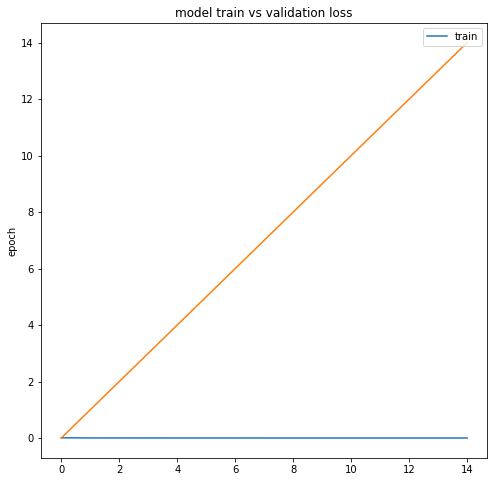

In [28]:
loss = history.history['loss']
epoch = range(len(loss))
plt.figure(figsize=(8,8))
plt.plot(loss)
plt.plot(epoch)
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.ylabel('epoch')
plt.legend(['train'],loc='upper right')
plt.show()

In [29]:
from tensorflow import keras
regressor = Sequential()
regressor = keras.models.load_model("LSTM_model_1210.h5")

In [30]:
past_60_days = data_training.tail(168)
df= past_60_days.append(data_test, ignore_index = True)
df = df.drop(['NewDateTime', 'Year','Week','NewDate'], axis = 1)
len(df)

1632

In [31]:
inputs = scaler.transform(df)
inputs

array([[0.65452527, 0.65660208, 0.6548204 , ..., 0.66220537, 0.72349041,
        0.57821885],
       [0.65532366, 0.65455284, 0.65058661, ..., 0.66996676, 0.73037763,
        0.57821885],
       [0.64930628, 0.65532376, 0.65043639, ..., 0.65196922, 0.71436414,
        0.57821885],
       ...,
       [0.76694578, 0.76614636, 0.76765255, ..., 0.66968714, 0.73012999,
        0.57712974],
       [0.76289807, 0.76694607, 0.76383424, ..., 0.65859775, 0.72027956,
        0.57712974],
       [0.76858408, 0.7628982 , 0.76523787, ..., 0.68092605, 0.74005511,
        0.57712974]])

In [32]:
X_test = []
Y_test = []
for i in range (168, inputs.shape[0]):
    X_test.append(inputs[i-168:i])
    Y_test.append(inputs[i, 0])

In [33]:
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape

((1464, 168, 8), (1464,))

In [34]:
Y_pred = regressor.predict(X_test)
Y_pred, Y_test

(array([[0.7761842 ],
        [0.77614677],
        [0.7760204 ],
        ...,
        [0.73705506],
        [0.7367965 ],
        [0.73629135]], dtype=float32),
 array([0.82680156, 0.82993408, 0.82240099, ..., 0.76694578, 0.76289807,
        0.76858408]))

In [35]:
scaler.scale_

array([1.65435222e-05, 1.65435249e-05, 1.65991634e-05, 1.65295076e-05,
       2.11614415e-05, 1.91062882e+00, 1.69385841e+00, 6.00335094e+00])

In [36]:
scale = 1/1.65435222e-05
scale

60446.62000695354

In [37]:
scale.inverse_transform(Y_pred)

AttributeError: 'float' object has no attribute 'inverse_transform'

In [38]:
Y_test = Y_test*scale
Y_pred = Y_pred*scale

In [39]:
Y_pred.shape

(1464, 1)

In [40]:
Y_test


array([49977.36000575, 50166.71000577, 49711.36000572, ...,
       46359.28000533, 46114.6100053 , 46458.31000534])

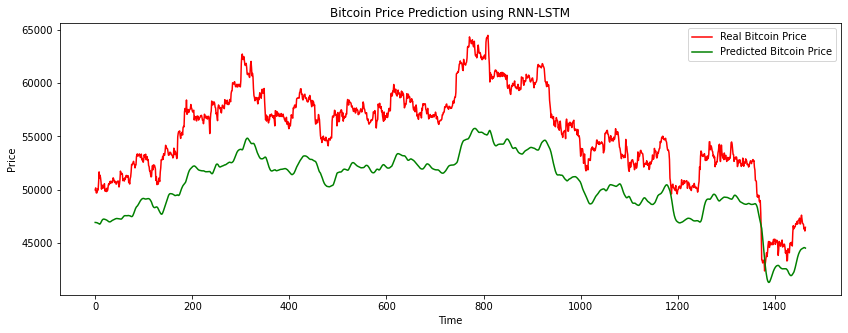

In [41]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()